<a href="https://colab.research.google.com/github/jaya-shankar/education-impact/blob/add_progress/tfr_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model Performace History

1.   Cosidering life expectancy as input
      
      1. *Training using max no of countries:*\
          **MSE**: 1.421960711479187
          
      2. *Training using min no of countries:*\
          **MSE**: 1.6800711154937744

      3. *Training using only common countries:*\
          **MSE**: 1.5712116956710815

2.   Not cosidering life expectancy as input
      1. *Trained using max no of countries:*\
          **MSE**: 1.9395439624786377

      2. *Trained using min no of countries*:\
          **MSE**: 2.161480665206909

      3. *Trained using only common countries*:\
          **MSE**: 2.10016131401062



In [ ]:
!rm -rf education-impact

rm: cannot remove 'education-impact': No such file or directory


In [1]:
!git clone https://github.com/jaya-shankar/education-impact.git


Cloning into 'education-impact'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (367/367), done.
remote: Compressing objects: 100% (309/309), done.
remote: Total 367 (delta 184), reused 175 (delta 55), pack-reused 0
Receiving objects: 100% (367/367), 3.90 MiB | 1.50 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [2]:
!pip install tensorflow_decision_forests
!pip install wurlitzer
!pip install seaborn

     |████████████████████████████████| 17.1 MB 347 kB/s 


In [3]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from wurlitzer import sys_pipes

In [4]:
#@title Default title text
root = "education-impact/datasets/" 
datasets_path = {
                    "infant_mortality"                :  root+ "Infant_Mortality_Rate.csv",
                    "child_mortality"                 :  root+ "child_mortality_0_5_year_olds_dying_per_1000_born.csv",
                    "children_per_woman"              :  root+ "children_per_woman_total_fertility.csv",
                    "co2_emissions_percapita"         :  root+ "co2_emissions_tonnes_per_person.csv",
                    "population"                      :  root+ "converted_pop.csv",
                    "population_density"              :  root+ "population_per_area.csv",
                    "gdp_growth"                      :  root+ "gdp_per_capita_yearly_growth.csv",
                    "Avg_daily_income_ppp"            :  root+ "mincpcap_cppp.csv",
                    "gdppercapita_us_infla_adjust"    :  root+ "gdppercapita_us_inflation_adjusted.csv",
                    "gini_index"                      :  root+ "gini.csv",
                    "life_expectancy"                 :  root+ "life_expectancy_years.csv",
                    "poverty_index"                   :  root+ "mincpcap_cppp.csv",
                    "people_in_poverty"               :  root+ "number_of_people_in_poverty.csv",
                    "ratio_b/g_in_primary"            :  root+ "ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv",
                    "wcde-25--34"                     :  root+ "wcde-25--34.csv",
                    "20-24-In_Primary_OL"             :  root+ "In_Primary_OL.csv",
                    "20-24-Primary_OL"                :  root+ "Primary_OL.csv",
                    "20-24-Lower_Secondary_OL"        :  root+ "Lower_Secondary_OL.csv",
                    "20-24_female-In_Primary_OL"      :  root+ "female_In_Primary_OL.csv",
                    "20-24_female-Primary_OL"         :  root+ "female_Primary_OL.csv",
                    "20-24_female-Lower_Secondary_OL" :  root+ "female_Lower_Secondary_OL.csv"
                }

In [10]:
PREDICT_FUTURE = 0
OUTPUT         = 'children_per_woman'

In [11]:
datasets_to_plot = [
            "infant_mortality",
            "child_mortality",
            "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            "20-24-In_Primary_OL",
            "20-24-Primary_OL",
            "20-24-Lower_Secondary_OL",
            "population",
            "population_density",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL" ,
            "20-24_female-Lower_Secondary_OL",
            "life_expectancy"
            ]

# creating a list of all countries & years
countries   = find_common_countries(datasets_to_plot)
years       = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys        = generate_indices(countries, years)

combined_df = load_datasets_to_pd(datasets_to_plot,keys,include_output=False)

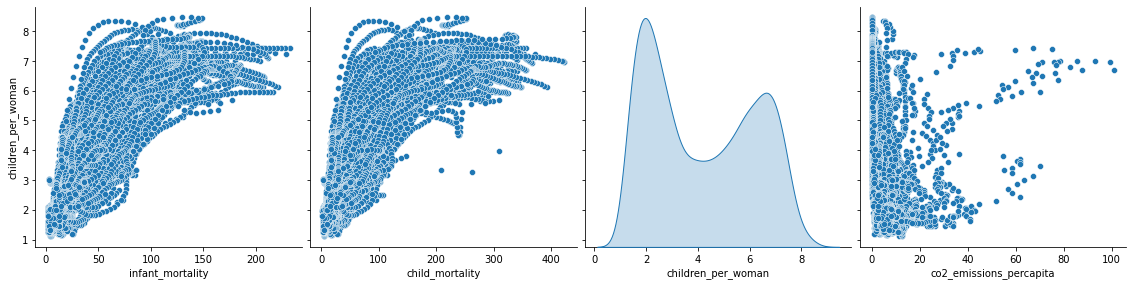

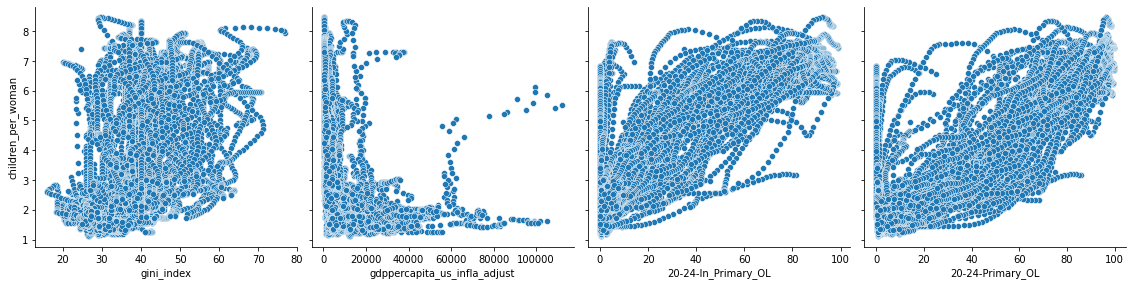

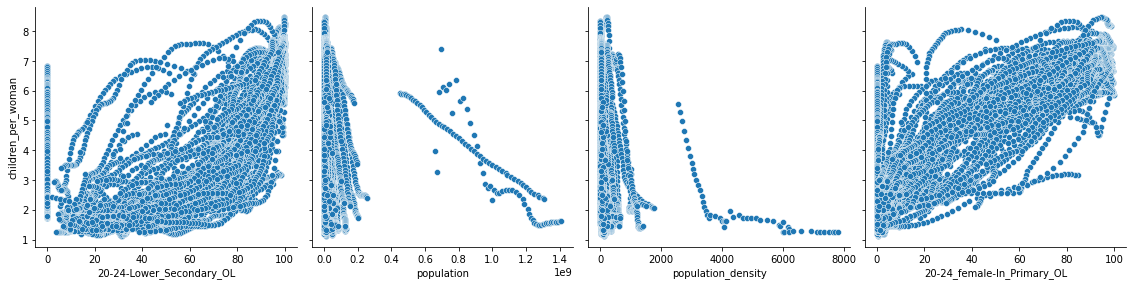

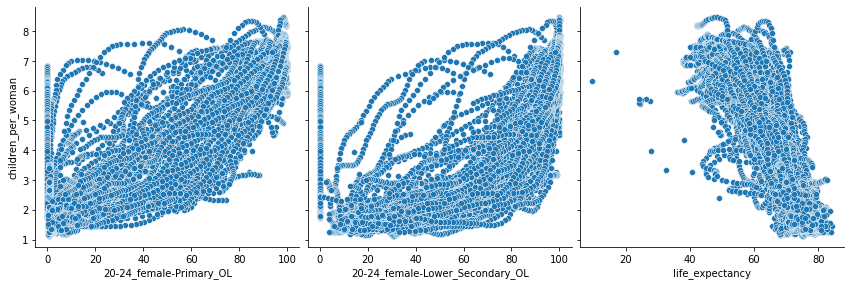

In [12]:
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

In [5]:
def get_countries_count(datasets):
  for dataset in datasets:
    df = pd.read_csv(datasets_path[dataset])
    count = len(set(df.Country.unique()))
    print(f"{'Factor: ' + dataset:<40} count: {count}")


In [6]:
def find_common_countries(datasets):
  common_countries = set()
  for dataset in datasets:
    countries_list = list(pd.read_csv(datasets_path[dataset]).Country)
    countries_list = set(map(lambda x: x.lower(), countries_list))
    if common_countries == set():
      common_countries = countries_list
    else:
      common_countries = common_countries.intersection(countries_list)
  return list(common_countries)

In [7]:
def generate_indices(countries,years):
  keys=[]
  for y in years:
    for c in countries:
      keys.append((c,str(y)))
  return keys

In [8]:
def load_datasets_to_pd(datasets,keys,include_output=True):
  combined_df = pd.DataFrame(keys,columns=['country','year'])
  for dataset in datasets:
    combined_df[dataset] = [math.nan]*len(combined_df)
    df = pd.read_csv(datasets_path[dataset])
    df["Country"] = df["Country"].str.lower()
    df.set_index("Country", inplace=True)
    for e in range(len(combined_df)):
      country = combined_df.iloc[e].country
      year    = combined_df.iloc[e].year
      combined_df.at[e,dataset] = df.loc[country][year]

  if include_output:
    label = "o_"+OUTPUT
    combined_df[label] = [math.nan]*len(combined_df)
    df = pd.read_csv(datasets_path[OUTPUT])
    df["Country"] = df["Country"].str.lower()
    df.set_index("Country", inplace=True)
    for e in range(len(combined_df)):
      country = combined_df.iloc[e].country
      year    = int(combined_df.iloc[e].year)
      combined_df.at[e,label] = df.loc[country][str( year + PREDICT_FUTURE )]
    # combined_df.set_index(["country","year"], inplace=True)
  return combined_df

  

In [9]:
def add_n_yrs_old_dataset(input_df,dataset,years):
  dataset_pf = pd.read_csv(datasets_path[dataset])
  dataset_pf["Country"] = dataset_pf["Country"].str.lower()
  dataset_pf.set_index("Country", inplace=True)

  label = dataset+"_"+str(years)+"years_before"
  input_df[label] = [math.nan]*len(input_df)

  for e in range(len(input_df)):
    country = input_df.iloc[e].country
    year    = int(input_df.iloc[e].year)
    try:
      input_df.at[e,label] = dataset_pf.loc[country][str( year - years )]
    except:
      pass

  return input_df

In [23]:
def combine_dfs(X,y):
  label = y.columns[0]
  X[label] = y
  X.dropna(subset=[label],inplace=True)
  return X

## Main Function starts from here

In [13]:
datasets = [
            "infant_mortality",
            "life_expectancy",
            "child_mortality",
            # "children_per_woman",
            "co2_emissions_percapita",
            "gdppercapita_us_infla_adjust",
            # "included 20 yrs old gdp"
            "20-24-In_Primary_OL",
            "20-24-Primary_OL",
            "20-24-Lower_Secondary_OL",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL" ,
            "20-24_female-Lower_Secondary_OL"
            ]

In [14]:
# PREDICT_FUTURE  = 10
# OUTPUT         = 'life_expectancy'
get_countries_count(datasets)

Factor: infant_mortality                 count: 266
Factor: life_expectancy                  count: 195
Factor: child_mortality                  count: 197
Factor: co2_emissions_percapita          count: 194
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 20-24-In_Primary_OL              count: 202
Factor: 20-24-Primary_OL                 count: 202
Factor: 20-24-Lower_Secondary_OL         count: 202
Factor: 20-24_female-In_Primary_OL       count: 202
Factor: 20-24_female-Primary_OL          count: 202
Factor: 20-24_female-Lower_Secondary_OL  count: 202


In [15]:
# creating a list of all countries & years
countries = find_common_countries(datasets)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [17]:
input_df            = load_datasets_to_pd(datasets,keys)
# input_df            = add_n_yrs_old_dataset(input_df,"gdppercapita_us_infla_adjust",20)
input_df.set_index(["country","year"], inplace=True)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [18]:
input_df

,,infant_mortality,life_expectancy,child_mortality,co2_emissions_percapita,gdppercapita_us_infla_adjust,20-24-In_Primary_OL,20-24-Primary_OL,20-24-Lower_Secondary_OL,20-24_female-In_Primary_OL,20-24_female-Primary_OL,20-24_female-Lower_Secondary_OL
country,year,,,,,,,,,,,
kiribati,1960,NaN,48.2,195.0,NaN,NaN,64.3,81.5,96.1,78.8,90.7,99.5
costa rica,1960,67.3,65.3,106.0,0.3690,3600.0,48.6,77.1,94.3,49.8,78.0,94.6
croatia,1960,NaN,64.7,70.3,1.3600,NaN,6.6,30.1,62.6,10.2,40.1,72.7
haiti,1960,190.6,45.4,283.0,0.0739,1670.0,89.3,93.7,99.8,92.0,95.1,99.9
mauritania,1960,129.8,50.6,253.0,0.0431,NaN,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
panama,2015,14.6,79.3,16.9,2.7400,13600.0,5.3,22.2,38.6,5.5,19.9,34.6
comoros,2015,54.1,67.5,74.9,0.2170,1240.0,20.5,51.5,71.7,19.3,50.5,70.3
finland,2015,2.0,81.7,2.2,8.0600,42800.0,0.0,5.7,32.0,0.0,5.9,30.8


In [19]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

In [20]:
X_train.isna().sum()

infant_mortality                    539
life_expectancy                       0
child_mortality                       0
co2_emissions_percapita              94
gdppercapita_us_infla_adjust       1313
20-24-In_Primary_OL                   0
20-24-Primary_OL                      0
20-24-Lower_Secondary_OL              0
20-24_female-In_Primary_OL            0
20-24_female-Primary_OL               0
20-24_female-Lower_Secondary_OL       0
dtype: int64

In [21]:
y_train.isna().sum()

o_children_per_woman    0
dtype: int64

In [24]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

94/94 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - mse: 0.0559
CHILDREN_PER_WOMAN
{'loss': 0.0, 'mse': 0.05585084110498428}

MSE: 0.05585084110498428
RMSE: 0.23632782549878523



In [25]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [26]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-In_Primary_OL
	20-24-Lower_Secondary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Lower_Secondary_OL
	20-24_female-Primary_OL
	child_mortality
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	infant_mortality
	life_expectancy

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                         "__LABEL" 11.546172 ################
    2.        "20-24-Lower_Secondary_OL"  8.386103 ##########
    3.    "gdppercapita_us_infla_adjust"  7.900018 #########
    4.             "20-24-In_Primary_OL"  7.662158 #########
    5.         "co2_emissions_percapita"  7.205872 ########
    6.         

# XGBoost Regressor 

In [ ]:
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [ ]:
input_df            = load_datasets_to_pd(datasets,keys)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

In [ ]:
# create an xgboost regression model
model = XGBRegressor()

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [ ]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 2.665 (0.124)


# DNN Algorithm

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

from the above output
- **malnutrition & people in povery** have least no of countries
- **infant mortality & gdp per captia** have highest no of countries

*Doubt:* Does having more data for one factor will make the decision tree bias?


###Steps
1. create a csv file such that each row contains all values of particular year & country present
2. the output for each row is year + 40 years corresponding value 
    1. **outputs** - life expectany, education level, gdp




From above output
- if we dont drop any rows our table size = 4256 entries
- if we drop rows containing any if all of outputs missing then our table size = 3039 entries
- if we drop rows containing any one of output missing then our table size = 1745 entries

so, I think its is better to go with second choice and build different models, but not sure it will not effect performance of the model


now we have the dataframe containing both inputs and ouputs,our next step is
1. split the data into train & test data
  1. try to split data based on continents to reduce bias
2. build DF model using tensorflow
3. check the accuracy of the model